In [1]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import Adam
import os
import matplotlib.pyplot as plt
from PIL import Image

# Class Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


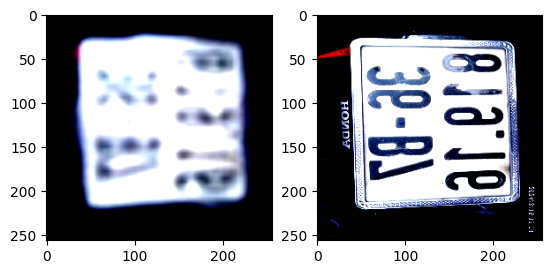

In [2]:
class LicensePlateDataset(Dataset):
    def __init__(self, LR_folder_path,HR_folder_path, resize_tup):
        super().__init__()
        self.LR_folder_path = LR_folder_path
        self.HR_folder_path = HR_folder_path
        self.resize_tup = resize_tup
        self.transforms = transforms.Compose([
            transforms.Resize(self.resize_tup),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),
                                (0.229, 0.224, 0.225))
        ])
    def __len__(self):
        if os.listdir(self.LR_folder_path) != os.listdir(self.HR_folder_path):
            raise ValueError("HR image number is not same LR image number!")

        return len(os.listdir(self.LR_folder_path))

    def __getitem__(self, index):
        LR_tail = os.listdir(self.LR_folder_path)
        LR_image = Image.open(os.path.join(self.LR_folder_path,LR_tail[index]))
        LR_image = self.transforms(LR_image)
        HR_tail = os.listdir(self.HR_folder_path)
        HR_image = Image.open(os.path.join(self.HR_folder_path,HR_tail[index]))
        HR_image = self.transforms(HR_image)
        return (LR_image, HR_image)

# Path of image folder
LR_path = r"D:\LicensePlate\project_enhance_quality_license_plate\data_no_augmentation\LR_data\LR_data"
HR_path = r"D:\LicensePlate\project_enhance_quality_license_plate\data_no_augmentation\HR_data\HR_data"
Dataset = LicensePlateDataset(LR_path, HR_path, (256,256))

image_test1 = Dataset.__getitem__(1)[0]
image_test1 = image_test1.transpose(2,0)
image_test2 = Dataset.__getitem__(1)[1]
image_test2 = image_test2.transpose(2,0)
plt.subplot(1,2,1)
plt.imshow(image_test1)
plt.subplot(1,2,2)
plt.imshow(image_test2)
plt.show()

# Model UNET

In [3]:
in_channels=3
out_channels=3
class DoubleConv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv=nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self,x):
        x=self.conv(x)
        return x

class UNET(nn.Module):
    def __init__(self, in_channels=in_channels, out_channels=out_channels, features=[64,128,256,512]):
        super().__init__()
        self.downs=nn.ModuleList()
        self.ups=nn.ModuleList()
        self.Maxpool2d=nn.MaxPool2d(kernel_size=2,stride=2)

        for feature in features:
            self.downs.append(DoubleConv2d(in_channels,feature))
            in_channels=feature

        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(in_channels=feature*2,out_channels=feature,padding=2,stride=2,kernel_size=2)
            )
            self.ups.append(DoubleConv2d(feature*2,feature))

        self.bottom=DoubleConv2d(features[-1],features[-1]*2)
        self.lastConv2d=nn.Conv2d(features[0],out_channels,kernel_size=1)

    def forward(self,x):
        skip_connections=[]
        for down in self.downs:
            x=down(x)
            skip_connections.append(x)
            x=self.Maxpool2d(x)

        x=self.bottom(x)
        skip_connections=skip_connections[::-1]

        for i in range(0,len(self.ups),2):
            x=self.ups[i](x)
            skip_connection=skip_connections[i//2]


            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
            x=torch.cat((x,skip_connection),dim=1)
            x=self.ups[i+1](x)

        x=self.lastConv2d(x)
        return x

In [10]:
model = UNET()
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params


31043651

In [9]:
import torch

# Giả sử tensor là một tensor trên GPU
torch.cuda.empty_cache()


# Training

In [15]:
epochs = 10
device = 'cuda'
loss_fn = nn.MSELoss()

image_dataset = LicensePlateDataset(LR_path, HR_path, (64, 64))
dataloader = DataLoader(image_dataset, batch_size=16, shuffle=True)
model = UNET(in_channels=3, out_channels=3)
model.to(device)
optimizer = Adam(model.parameters(),lr=0.001)

for epoch in range(epochs):
  model.train()
  sum_loss = 0
  n=len(dataloader)
  for LR_image, HR_image in dataloader:
        LR_image, HR_image = LR_image.to(device), HR_image.to(device)
        optimizer.zero_grad()
        HR_output = model(LR_image)
        loss = loss_fn(HR_output, HR_image)
        loss.backward()
        optimizer.step()
        sum_loss+=loss
  print("Epoch {} : Loss {}".format(epoch+1,sum_loss/n))

Epoch 1 : Loss 0.11153893172740936
Epoch 2 : Loss 0.07732642441987991
Epoch 3 : Loss 0.06770212203264236
Epoch 4 : Loss 0.06088869646191597
Epoch 5 : Loss 0.05383393540978432
Epoch 6 : Loss 0.05101767182350159
Epoch 7 : Loss 0.04535011202096939
Epoch 8 : Loss 0.04244247078895569
Epoch 9 : Loss 0.04074469953775406
Epoch 10 : Loss 0.03897004574537277


# Save Model

In [16]:

torch.save(model.state_dict(), 'UNET64_model_weights.pth')


# Load Model


In [4]:
model_path = "UNET64_model_weights.pth"
model = UNET()
model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

# Inference


d:\image_clf\venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..

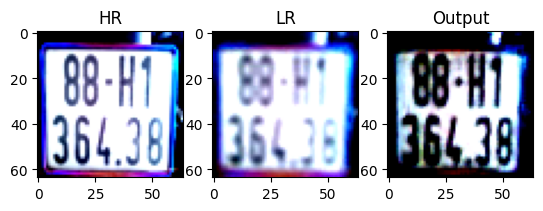

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


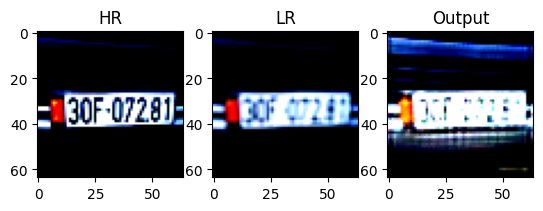

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


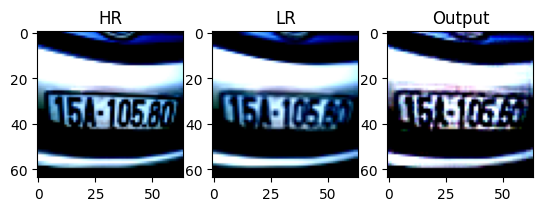

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


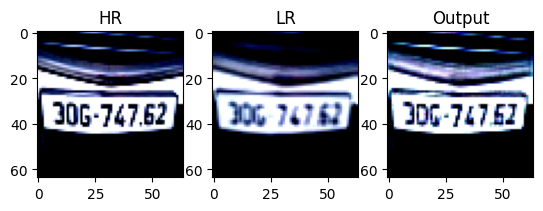

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


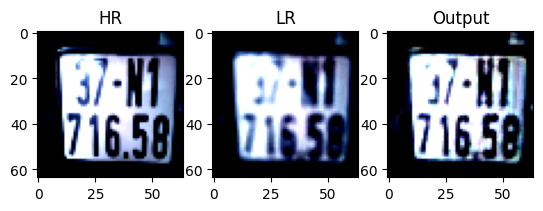

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


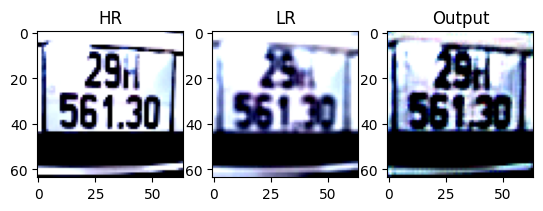

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


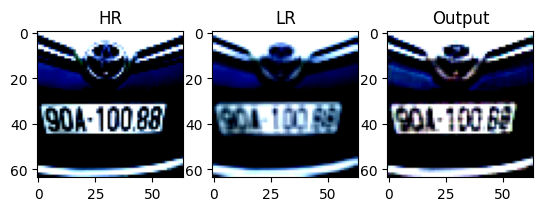

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


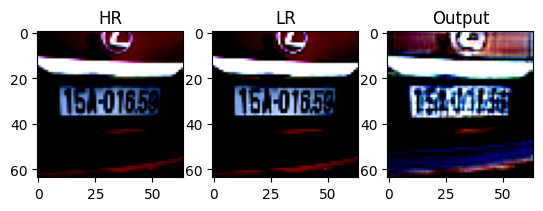

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


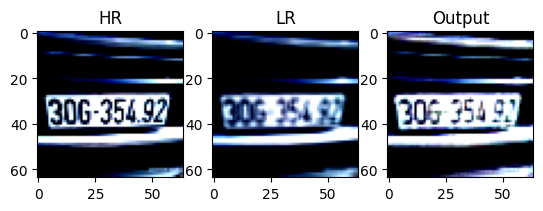

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


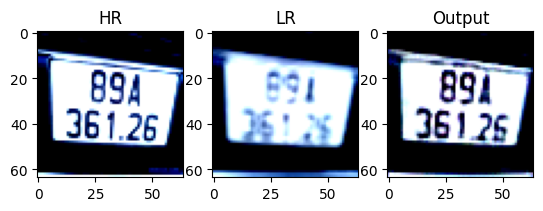

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


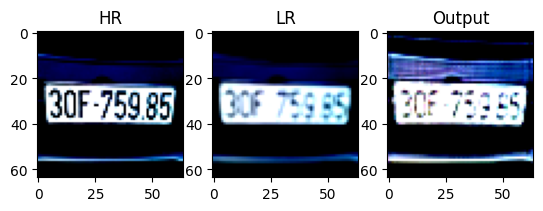

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


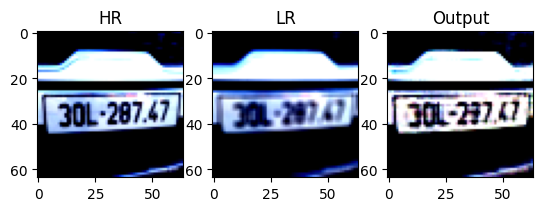

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


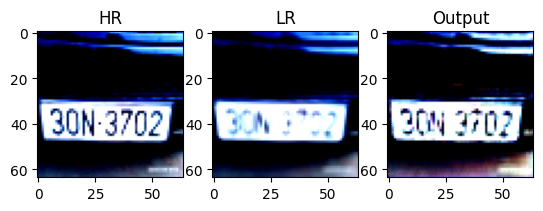

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


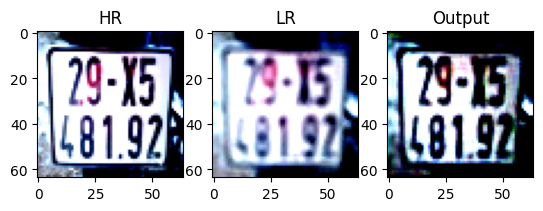

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


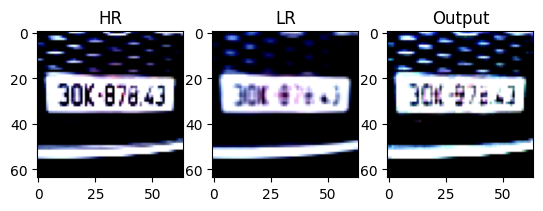

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


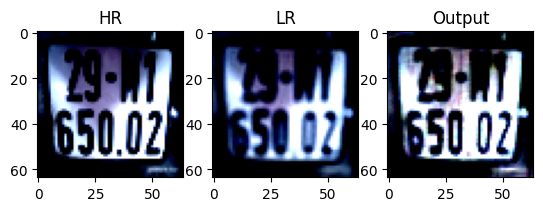

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


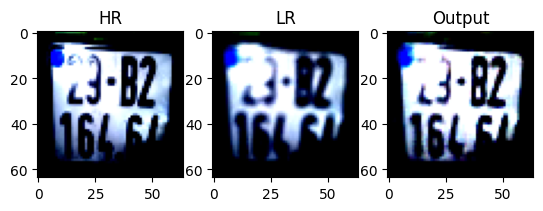

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


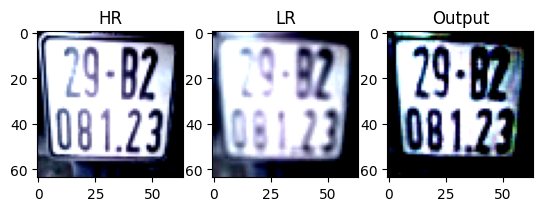

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


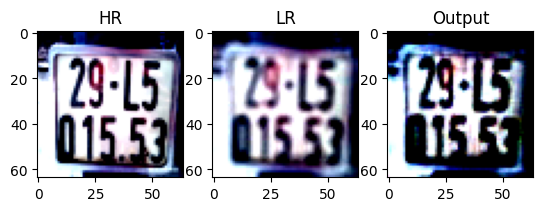

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


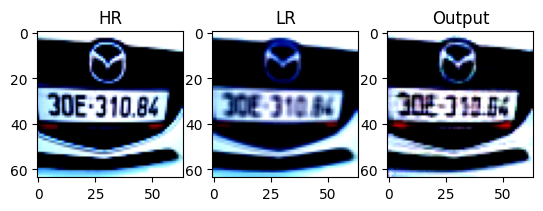

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


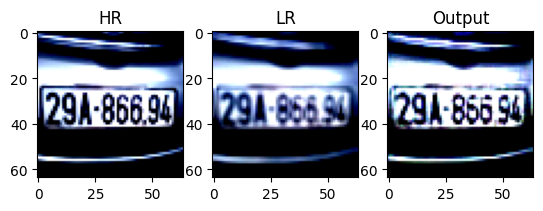

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


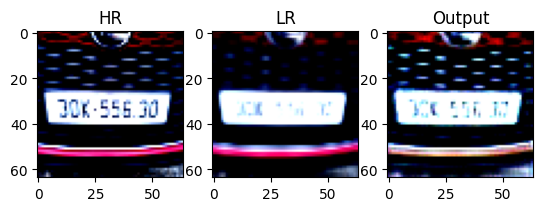

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


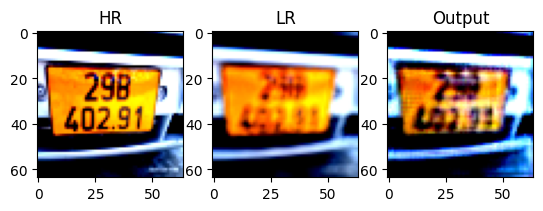

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


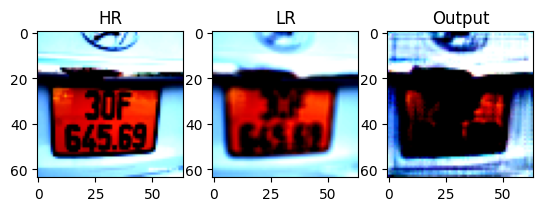

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


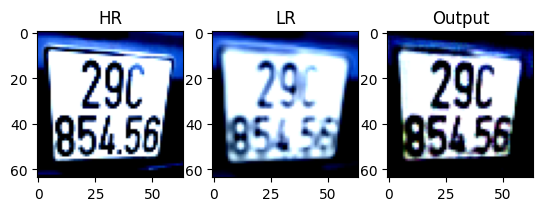

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


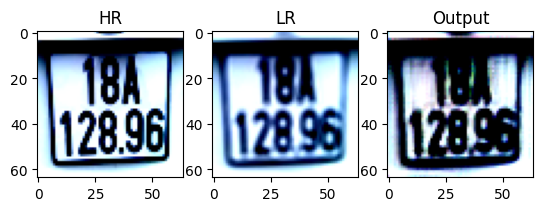

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


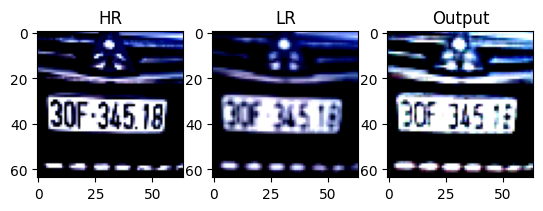

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


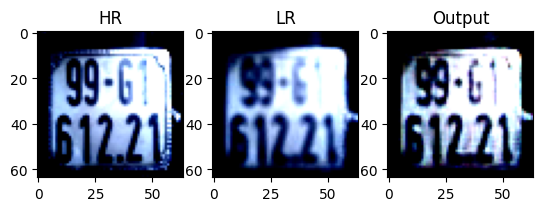

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


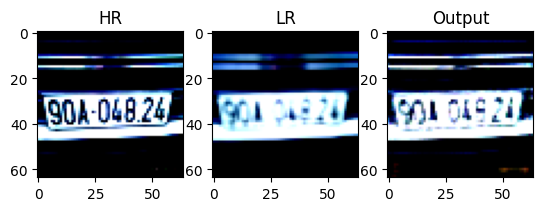

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


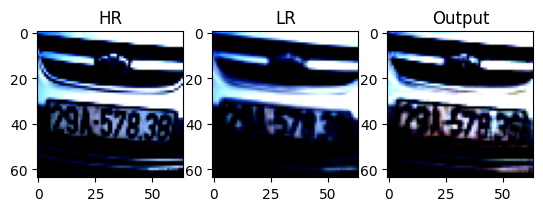

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


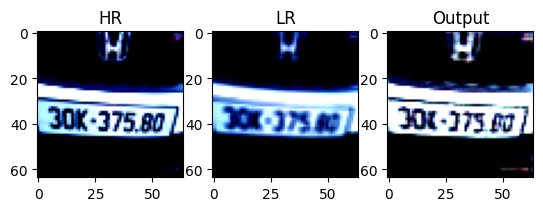

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


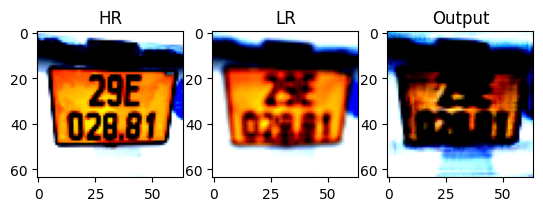

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


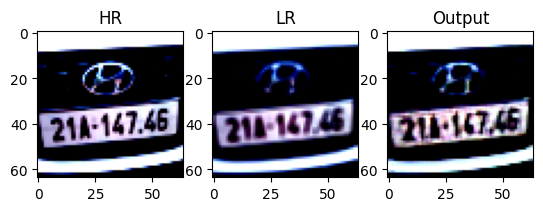

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


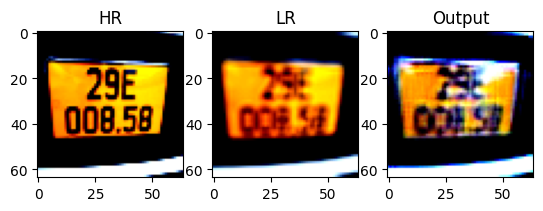

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


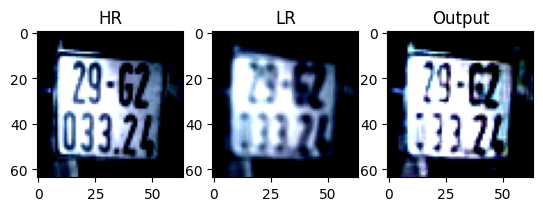

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


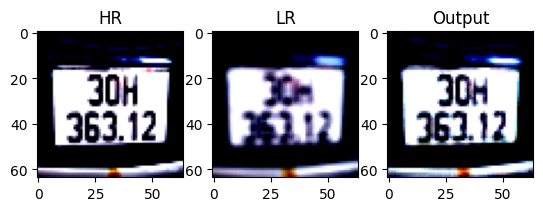

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


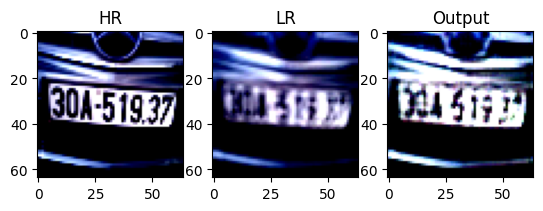

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


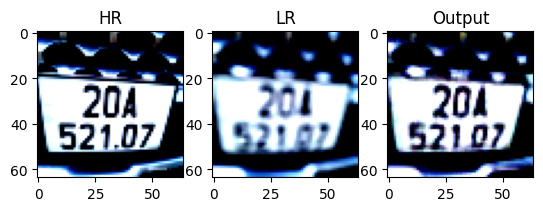

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


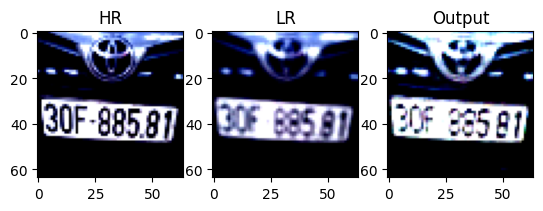

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


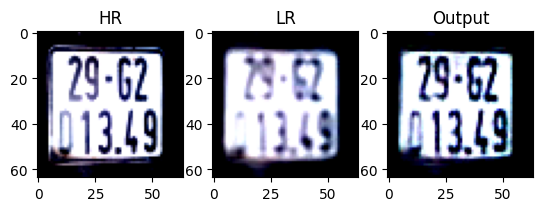

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


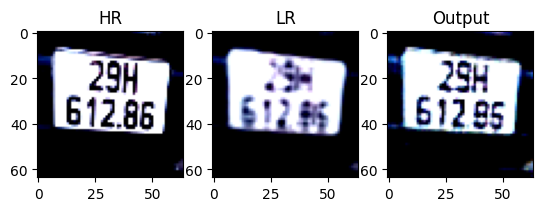

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


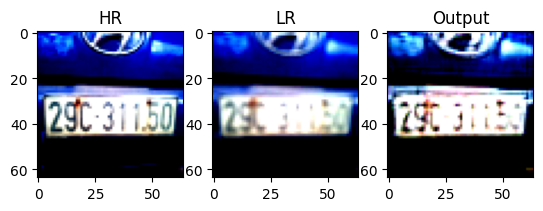

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


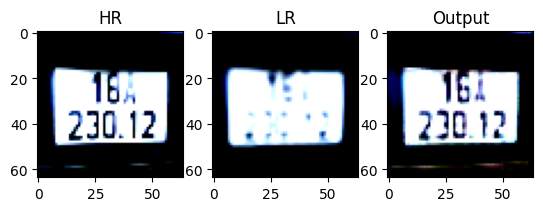

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


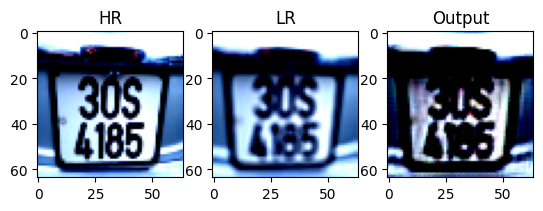

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


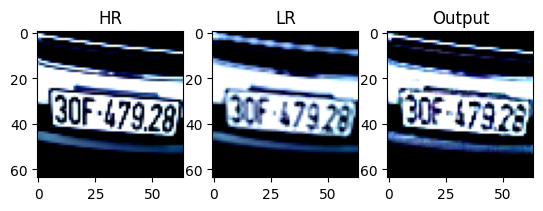

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


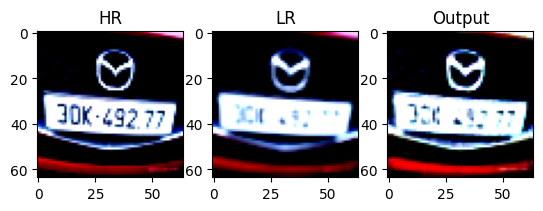

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


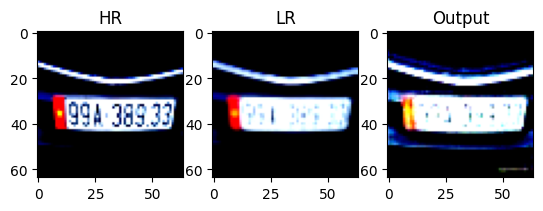

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


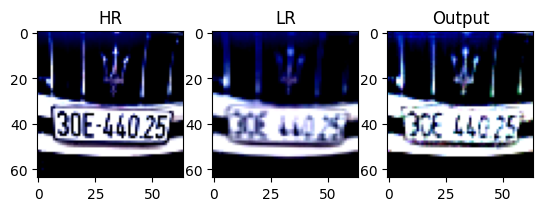

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


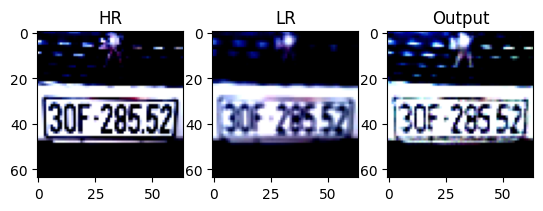

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


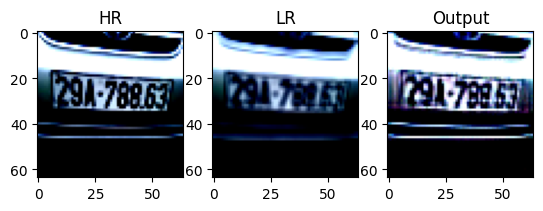

In [7]:
device = 'cuda'
model.to(device)
image_dataset = LicensePlateDataset(LR_path, HR_path, (64, 64))
dataloader = DataLoader(image_dataset, batch_size=1, shuffle=True)
i=0
for LR_image, HR_image in dataloader:
        if i == 50:
                break
        LR_image, HR_image = LR_image.to(device), HR_image.to(device)
        HR_output = model(LR_image)
        HR_output = HR_output.squeeze(0)
        HR_output = HR_output.permute(1, 2, 0)
        HR_output = HR_output.cpu().detach().numpy()
        plt.subplot(1,3,1)
        plt.imshow(HR_image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
        plt.title("HR")
        plt.subplot(1,3,2)
        plt.imshow(LR_image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
        plt.title("LR")
        plt.subplot(1,3,3)
        plt.imshow(HR_output)
        plt.title("Output")
        plt.show()
        i+=1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


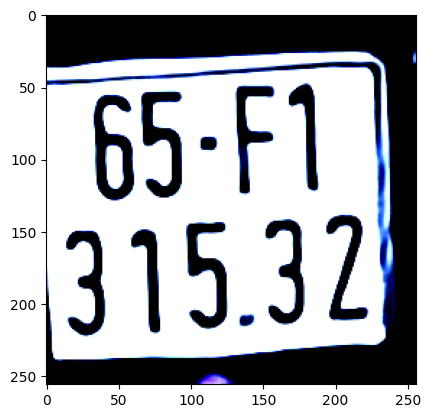

In [27]:
def inference(image, model):
    image = model(image)
    image = image.squeeze(0).permute(1,2,0).detach().cpu().numpy()
    return image
LR_path = r"D:\LicensePlate\project_enhance_quality_license_plate\data_augmentation\img_HRsumary4357\img_HRsumary"
HR_path = r"D:\LicensePlate\project_enhance_quality_license_plate\data_augmentation\img_LRsumary4357\img_LRsumary"
dataset = LicensePlateDataset(LR_path, HR_path, (256,256))
LR_image = dataset.__getitem__(0)[0]
HR_output = inference(LR_image.unsqueeze(0).to(device), model)
print(HR_output.shape)
# HR_output = HR_output.permute(1,2,0).detach().cpu().numpy()
# LR_image = LR_image.transpose(2,0)
plt.imshow(HR_output)

In [8]:
import numpy as np
import cv2


def calculate_psnr(original, compressed):
    # Đảm bảo hai hình ảnh có cùng kích thước
    assert original.shape == compressed.shape, "Hình ảnh phải có cùng kích thước"

    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return float('inf')  # PSNR vô cùng nếu không có sai khác

    max_pixel = 4.5  # Giả sử hình ảnh có độ sâu 8-bit
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr



In [9]:
from skimage.metrics import structural_similarity as ssim
import cv2
import numpy as np

def calculate_ssim(img1, img2):
    
    if img1.shape != img2.shape:
        raise ValueError("Hai ảnh phải có cùng kích thước.")

    # Tách các kênh màu (RGB)
    ssim_values = []
    for i in range(3):  # Duyệt qua 3 kênh màu
        ssim_value = ssim(img1[:, :, i], img2[:, :, i], data_range=img2[:, :, i].max() - img2[:, :, i].min())
        ssim_values.append(ssim_value)

    # Tính SSIM trung bình trên 3 kênh
    return np.mean(ssim_values)


In [10]:
import cv2
import numpy as np

def calculate_nmse(img1, img2):
    
    # Kiểm tra kích thước ảnh
    if img1.shape != img2.shape:
        raise ValueError("Hai ảnh phải có cùng kích thước.")

    # Tính NMSE
    numerator = np.sum((img1 - img2) ** 2)
    denominator = np.sum(img2 ** 2)
    nmse_value = numerator / denominator if denominator != 0 else float('inf')
    return nmse_value



In [11]:
import numpy as np
device = 'cuda'
model.to(device)
psnr_score = []
ssim_score = []
nmse_score = []
image_dataset = LicensePlateDataset(LR_path, HR_path, (64, 64))
dataloader = DataLoader(image_dataset, batch_size=1, shuffle=False)
for LR_image, HR_image in dataloader:
        LR_image, HR_image = LR_image.to(device), HR_image.to(device)
        HR_output = model(LR_image)
        HR_output = HR_output.squeeze(0)
        HR_output = HR_output.permute(1, 2, 0)
        HR_output = HR_output.detach().cpu().numpy()
        
        HR_image = HR_image.squeeze(0).permute(1,2,0)
        HR_image = HR_image.detach().cpu().numpy()
        psnr_score.append(calculate_psnr(HR_image,HR_output))
        ssim_score.append(calculate_ssim(HR_image,HR_output))
        nmse_score.append(calculate_nmse(HR_image,HR_output))

D:\image_clf\venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


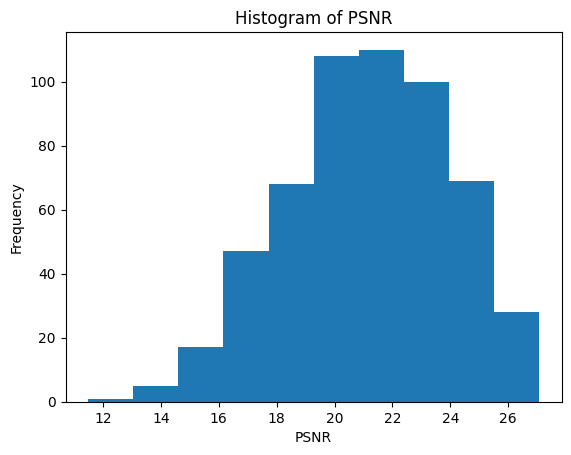

In [12]:
plt.hist(psnr_score)
plt.xlabel("PSNR")
plt.ylabel("Frequency")
plt.title("Histogram of PSNR")
plt.show()

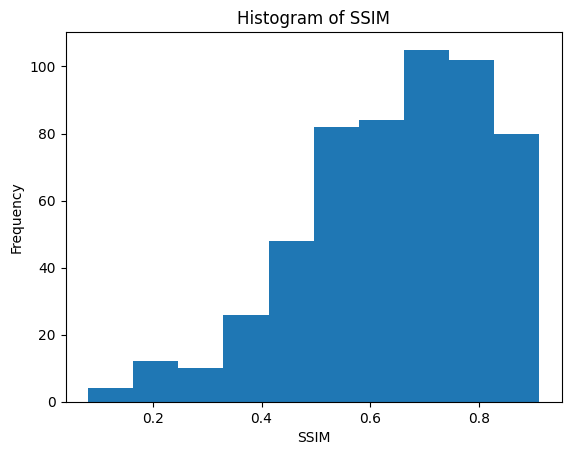

In [13]:
plt.hist(ssim_score)
plt.xlabel("SSIM")
plt.ylabel("Frequency")
plt.title("Histogram of SSIM")
plt.show()

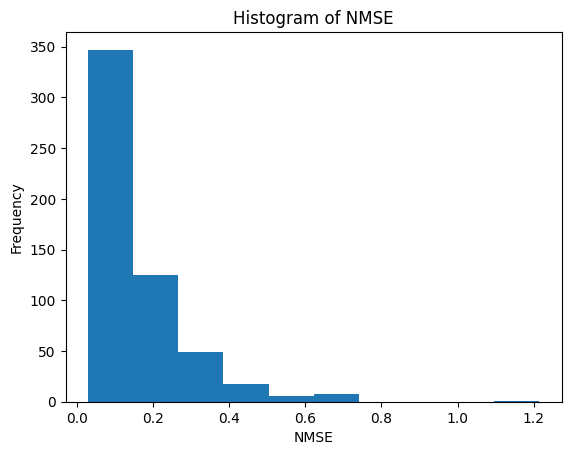

In [14]:
plt.hist(nmse_score)
plt.xlabel("NMSE")
plt.ylabel("Frequency")
plt.title("Histogram of NMSE")
plt.show()

In [15]:
import pandas as pd
AE_dict = {"METHOD":"Auto Encoder","PSNR":psnr_score, "SSIM":ssim_score,"NMSE":nmse_score}
AE_df = pd.DataFrame(AE_dict)
AE_df.head()

METHOD       PSNR      SSIM      NMSE
0  Auto Encoder  25.770548  0.902628  0.041807
1  Auto Encoder  23.852997  0.808510  0.063651
2  Auto Encoder  23.297876  0.747898  0.076661
3  Auto Encoder  24.362293  0.814679  0.056774
4  Auto Encoder  22.217353  0.763054  0.099772

In [16]:
AE_df.shape

(553, 4)

In [18]:
AE_df.to_csv("AE_df.csv")